In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Importing Required Libraries
import numpy as np
from numpy import mean
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve
import itertools
import matplotlib.pyplot as plt
import shap


In [3]:
##FUNCTIONS
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

            
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

def plot_confusion_matrix(cm,lag, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()
    output_dir = "/Users/markrademaker/Projects/Sea-scape-analysis/RF/"
    fig.savefig(output_dir+'SHAP_Lag_{}_RF_Fecundity.png'.format(lag), dpi = 300, bbox_inches='tight')
    return 
    
def f(row):
    if row['Causal lag 1'] + row['Causal lag 2'] > 0:
        val = 1
    else:
        val = 0
    return val

# LAG  0

In [4]:
user = "/Users/markrademaker/Projects/Sea-scape-analysis/"

data = pd.read_csv(user+"RF/RF_table.csv")
data.columns

## Objective function to predict Causal lag 0 
exit_status_map = {'yes': 1, 'no': 0}
data['Causal lag 0'] = data['Causal lag 0'].map(exit_status_map)
#len(data)

## Keep rows of neighbouring seascapes
#data = data.loc[data['Neighbouring'] == "yes"]
#len(data)

print(len(data.loc[data["Causal lag 0"] == 1]))
#absolute values for biomass differences and check
data['Diff LQL Juv']=np.abs(data['Diff LQL Juv'])#
data['Diff UQL Juv']=np.abs(data['Diff UQL Juv'])
data['Diff LQL Adult']=np.abs(data['Diff LQL Adult'])
data['Diff UQL Adult']=np.abs(data['Diff UQL Adult'])
#data['Diff Juv Biomass'] = np.abs(data['Diff Juv Biomass'])
#data['Diff Adult Biomass']=np.abs(data["Diff Adult Biomass"])
#print ((data['Diff LQL Juv'] >= 0).all())
#print ((data['Diff UQL Juv'] >= 0).all())
#print ((data['Diff LQL Adult'] >= 0).all())
#print ((data['Diff UQL Adult'] >= 0).all())


X = data.drop(['Unnamed: 0','Neighbouring','Causal lag 1','Causal lag 2',"Diff Juv Biomass","Diff Adult Biomass","Spawning type"],axis = 1)
#spawning type dropped as constant across all species (non-guarder)
y = X.pop('Causal lag 0')
X.columns
print(len(X.columns))
#seed = 4  # so that the result is reproducible
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed)

#list categorical variables to encode
#X_train.dtypes
X.dtypes
features_to_encode = list(X.select_dtypes(include = ['object']).columns) 
print(features_to_encode)

for feature in features_to_encode:
    print(feature)
    X = encode_and_bind(X, feature)
#X = pd.DataFrame(make_column_transformer(
#                        (OneHotEncoder(),features_to_encode),
#                        remainder = "passthrough"
#                        ))
#X.head()
#train subset
print(len(X)*0.05)
X.columns = X.columns.str.replace('_', ' ')
print(len(list(X.columns)))
print(np.sqrt(int(len(list(X.columns)))))
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)

Index(['Unnamed: 0', 'Seascape combination', 'Neighbouring', 'Species',
       'Causal lag 0', 'Causal lag 1', 'Causal lag 2', 'Year', 'Diff LQL Juv',
       'Diff UQL Juv', 'Diff Juv Biomass', 'Diff LQL Adult', 'Diff UQL Adult',
       'Diff Adult Biomass', 'Family', 'Seasonal migration', 'Fecundity',
       'Spawning type', 'Age at Maturity', 'Maximum age', 'Habitat',
       'Feeding mode', 'Body type', 'Maximum length', 'Length at maturity'],
      dtype='object')

3066


Index(['Seascape combination', 'Species', 'Year', 'Diff LQL Juv',
       'Diff UQL Juv', 'Diff LQL Adult', 'Diff UQL Adult', 'Family',
       'Seasonal migration', 'Fecundity', 'Age at Maturity', 'Maximum age',
       'Habitat', 'Feeding mode', 'Body type', 'Maximum length',
       'Length at maturity'],
      dtype='object')

17


Seascape combination     object
Species                  object
Year                      int64
Diff LQL Juv            float64
Diff UQL Juv            float64
Diff LQL Adult          float64
Diff UQL Adult          float64
Family                   object
Seasonal migration       object
Fecundity               float64
Age at Maturity         float64
Maximum age             float64
Habitat                  object
Feeding mode             object
Body type                object
Maximum length          float64
Length at maturity      float64
dtype: object

['Seascape combination', 'Species', 'Family', 'Seasonal migration', 'Habitat', 'Feeding mode', 'Body type']
Seascape combination
Species
Family
Seasonal migration
Habitat
Feeding mode
Body type
850.5
81
9.0


In [ ]:
#set class weight
class_weight = dict({0:1, 1:4.5})
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

rdf = RandomForestClassifier(random_state = 1,class_weight=class_weight) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20,40], 
              'min_samples_split': [5, 10, 15,10],
              'min_samples_leaf' : [4, 8, 12,16],
              'n_estimators' : [300, 400, 500,600]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

In [5]:
#set class weight
class_weight = dict({0:1, 1:4.5})
# define model
#model = RandomForestClassifier(bootstrap=True,
#            class_weight=class_weight, 
#            criterion='gini',
#            max_depth=8, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=4, min_samples_split=10,
#            min_weight_fraction_leaf=0.0, n_estimators=300,
#            oob_score=False,
#            random_state=1,
#            verbose=0, warm_start=False)
model = RandomForestClassifier(bootstrap=True, 
                               class_weight=class_weight,
                               max_depth=40,
                               max_features='auto', 
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.0, 
                               min_impurity_split=None,
                               min_samples_leaf=10, 
                               min_samples_split=10,
                               min_weight_fraction_leaf=0.0,
                               n_estimators=300, 
                               n_jobs=-1,
                               oob_score=True,
                               random_state=1,
                               verbose=0, 
                               warm_start=False)


#model = BalancedRandomForestClassifier(min_samples_leaf=50,
#                                       n_estimators=150,
#                                       bootstrap = True,
#                                       oob_score = True,
#                                       n_jobs = -1,
#                                       class_weight=class_weight,
#                                       random_state = 1,
#                                       max_features = 'auto')

# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.980


RandomForestClassifier(class_weight={0: 1, 1: 4.5}, max_depth=40,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=1)

0.9786008230452675

The accuracy of the model is 97.89999999999999 %
Train ROC AUC Score: 0.9992242115059856
Test ROC AUC  Score: 0.9951015942576388


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves')

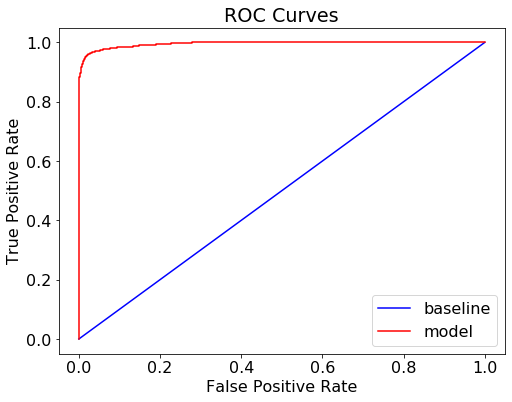

Recall Baseline: 1.0 Test: 0.95 Train: 0.99
Precision Baseline: 0.18 Test: 0.93 Train: 0.95
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


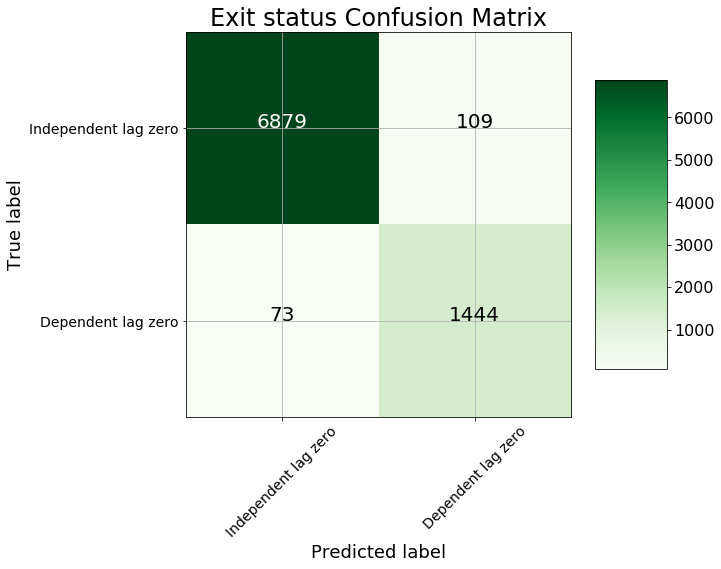

In [6]:
#EVALUATION
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

train_probs = model.predict_proba(X_train)[:,1] 
probs = model.predict_proba(X_test)[:, 1]
train_predictions = model.predict(X_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')


# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,lag="zero",classes = ['Independent lag zero', 'Dependent lag zero'],
                      title = 'Exit status Confusion Matrix')

#fig.savefig(output_dir+'RF_CM_Lag_Zero.png', dpi = 300, bbox_inches='tight')

In [7]:
## Interpreting the RF-model / variable importance with SHAP values
explainer = shap.TreeExplainer(model,data=X_train[:500],feature_perturbation='interventional')
print("finished explainer")
#shap_values = shap.TreeExplainer(model).shap_values(X_test[:1000])
#print("finished computing shap, building plot")
#shap_values = explainer.shap_values(X_test,)

finished explainer


In [10]:
shap_values = explainer.shap_values(X_test,approximate=False)

100%|===================| 16997/17010 [09:18<00:00]        

In [ ]:
from matplotlib import colors as plt_colors

shap.summary_plot(shap_values[1],X_test,max_display=5, show=False,plot_type="dot")


fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)

ax = plt.gca()
# Plot the summary without showing it
#plt.figure()
#shap.summary_plot(shap_values[1],X_test,max_display=10, show=False,plot_type="dot")
#shap.summary_plot(shap_values_XGB_train, X_train, show=False)

# Change the colormap of the artists
my_cmap = plt.get_cmap('bwr')

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

cb = plt.colorbar(ticks=[0,1])
cb.set_label(label='Feature value', size='large',weight="bold",fontname="Arial",labelpad=-10)
cb.ax.set_yticklabels(["Low", "High"],weight="bold",fontname="Arial") 
#cb.ax.tick_params(labelsize='large')
#ax.set_xticklabels(rotation=180)


plt.title("Feature importance 0 year time-lag",fontweight="bold",fontname="Arial")
plt.xlabel("SHAP value (impact on model output)",fontweight="bold",fontname="Arial",fontsize=20)

#cbar = plt.colorbar(heatmap)
#cbar.ax.set_yticklabels(['0','1','2','>3'])
#cbar.set_label('# of contacts', rotation=270)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")
# Plot the summary without showing it
plt.figure()
#plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
plt.show()
output_dir = "/Users/markrademaker/Projects/Sea-scape-analysis/RF/"
fig.savefig(output_dir+'SHAP_Lag_zero_RF.png', dpi = 300, bbox_inches='tight')

In [ ]:
shap.dependence_plot("Fecundity", shap_values[1], X_test,interaction_index=None, show=False,dot_size=60,alpha=0.5)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)
ax = plt.gca()
#plt.xlim(left=0,right=1000000)


#plt.title("SHAP dependence plot Maximum Age",fontweight="bold",fontname="Arial")
plt.xlabel("Fecundity",fontweight="bold",fontname="Arial",fontsize=20)
plt.ylabel("SHAP value (impact on model output)",fontweight="bold",fontname="Arial",fontsize=20)


#cbar = plt.colorbar(heatmap)
#cbar.ax.set_yticklabels(['0','1','2','>3'])
#cbar.set_label('# of contacts', rotation=270)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")

plt.show()
output_dir = "/Users/markrademaker/Projects/Sea-scape-analysis/RF/"
fig.savefig(output_dir+'SHAP_Lag_zero_RF_Fecundity.png', dpi = 300, bbox_inches='tight')

In [ ]:
shap.dependence_plot("Fecundity", shap_values[1], X_test,show=False,interaction_index=None,dot_size=60,alpha=0.5)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)
ax = plt.gca()
#plt.xlim(left=0,right=1000000)
plt.xlabel("Fecundity",fontweight="bold",fontname="Arial",fontsize=20)
plt.ylabel("SHAP value",fontweight="bold",fontname="Arial",fontsize=20)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")

plt.show()


# Lag 1-2

In [4]:
user = "/Users/markrademaker/Projects/Sea-scape-analysis/"

data = pd.read_csv(user+"RF/RF_table.csv")
data.columns

## Objective function to predict Causal lag 0 
exit_status_map = {'yes': 1, 'no': 0}
data['Causal lag 1'] = data['Causal lag 1'].map(exit_status_map)
data['Causal lag 2'] = data['Causal lag 2'].map(exit_status_map)
data['Causal lag 1-2'] = data.apply(f,axis=1)
print(len(data.loc[data["Causal lag 1-2"]==1]))

data['Diff LQL Juv']=np.abs(data['Diff LQL Juv'])#
data['Diff UQL Juv']=np.abs(data['Diff UQL Juv'])
data['Diff LQL Adult']=np.abs(data['Diff LQL Adult'])
data['Diff UQL Adult']=np.abs(data['Diff UQL Adult'])
#data['Diff LQL Juv']=np.abs(data['Diff LQL Juv'])
#data['Diff UQL Juv']=np.abs(data['Diff UQL Juv'])
#data['Diff LQL Adult']=np.abs(data['Diff LQL Adult'])
#data['Diff UQL Adult']=np.abs(data['Diff UQL Adult'])

y = data.pop("Causal lag 1-2")
X = data.drop(['Unnamed: 0','Neighbouring','Causal lag 0','Causal lag 1','Causal lag 2',"Diff Adult Biomass","Diff Juv Biomass","Spawning type"],axis=1)

X.columns

X.dtypes
features_to_encode = list(X.select_dtypes(include = ['object']).columns) 
print(features_to_encode)

for feature in features_to_encode:
    print(feature)
    X = encode_and_bind(X, feature)

    
print(len(X))
X.columns = X.columns.str.replace('_', ' ')
print(len(list(X.columns)))
print(np.sqrt(int(len(list(X.columns)))))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=1)

Index(['Unnamed: 0', 'Seascape combination', 'Neighbouring', 'Species',
       'Causal lag 0', 'Causal lag 1', 'Causal lag 2', 'Year', 'Diff LQL Juv',
       'Diff UQL Juv', 'Diff Juv Biomass', 'Diff LQL Adult', 'Diff UQL Adult',
       'Diff Adult Biomass', 'Family', 'Seasonal migration', 'Fecundity',
       'Spawning type', 'Age at Maturity', 'Maximum age', 'Habitat',
       'Feeding mode', 'Body type', 'Maximum length', 'Length at maturity'],
      dtype='object')

1344


Index(['Seascape combination', 'Species', 'Year', 'Diff LQL Juv',
       'Diff UQL Juv', 'Diff LQL Adult', 'Diff UQL Adult', 'Family',
       'Seasonal migration', 'Fecundity', 'Age at Maturity', 'Maximum age',
       'Habitat', 'Feeding mode', 'Body type', 'Maximum length',
       'Length at maturity'],
      dtype='object')

Seascape combination     object
Species                  object
Year                      int64
Diff LQL Juv            float64
Diff UQL Juv            float64
Diff LQL Adult          float64
Diff UQL Adult          float64
Family                   object
Seasonal migration       object
Fecundity               float64
Age at Maturity         float64
Maximum age             float64
Habitat                  object
Feeding mode             object
Body type                object
Maximum length          float64
Length at maturity      float64
dtype: object

['Seascape combination', 'Species', 'Family', 'Seasonal migration', 'Habitat', 'Feeding mode', 'Body type']
Seascape combination
Species
Family
Seasonal migration
Habitat
Feeding mode
Body type
17010
81
9.0


In [ ]:
#set class weight
class_weight = dict({0:1, 1:11.5})
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

rdf = RandomForestClassifier(random_state = 1,class_weight=class_weight) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20,40], 
              'min_samples_split': [5, 10, 15,10],
              'min_samples_leaf' : [4, 8, 12,16],
              'n_estimators' : [300, 400, 500,600]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

In [5]:
#set class weight
class_weight = dict({0:1, 1:11.5})
# define model
#model = RandomForestClassifier(bootstrap=True,
#            class_weight=class_weight, 
#            criterion='gini',
#            max_depth=8, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=4, min_samples_split=10,
#            min_weight_fraction_leaf=0.0, n_estimators=300,
#            oob_score=False,
#            random_state=1,
#            verbose=0, warm_start=False)
model = RandomForestClassifier(bootstrap=True, 
                               class_weight=class_weight,
                               max_depth=40,
                               max_features='auto', 
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.0, 
                               min_impurity_split=None,
                               min_samples_leaf=10, 
                               min_samples_split=15,
                               min_weight_fraction_leaf=0.0,
                               n_estimators=500, 
                               n_jobs=-1,
                               oob_score=True,
                               random_state=1,
                               verbose=0, 
                               warm_start=False)


#model = BalancedRandomForestClassifier(min_samples_leaf=50,
#                                       n_estimators=150,
#                                       bootstrap = True,
#                                       oob_score = True,
#                                       n_jobs = -1,
#                                       class_weight=class_weight,
#                                       random_state = 1,
#                                       max_features = 'auto')

# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.982


RandomForestClassifier(class_weight={0: 1, 1: 11.5}, max_depth=40,
                       min_samples_leaf=10, min_samples_split=15,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=1)

0.9904761904761905

The accuracy of the model is 99.0 %
Train ROC AUC Score: 0.9999177322895901
Test ROC AUC  Score: 0.9973718827666221


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves')

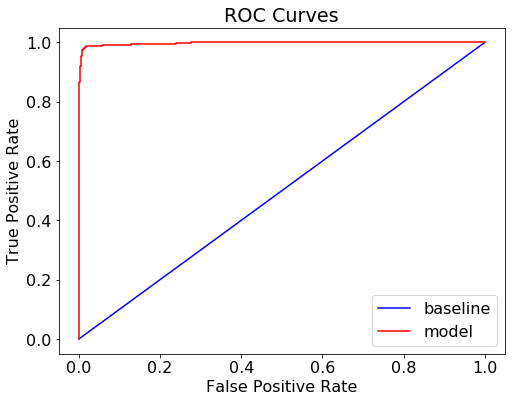

Recall Baseline: 1.0 Test: 0.97 Train: 1.0
Precision Baseline: 0.08 Test: 0.92 Train: 0.94
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


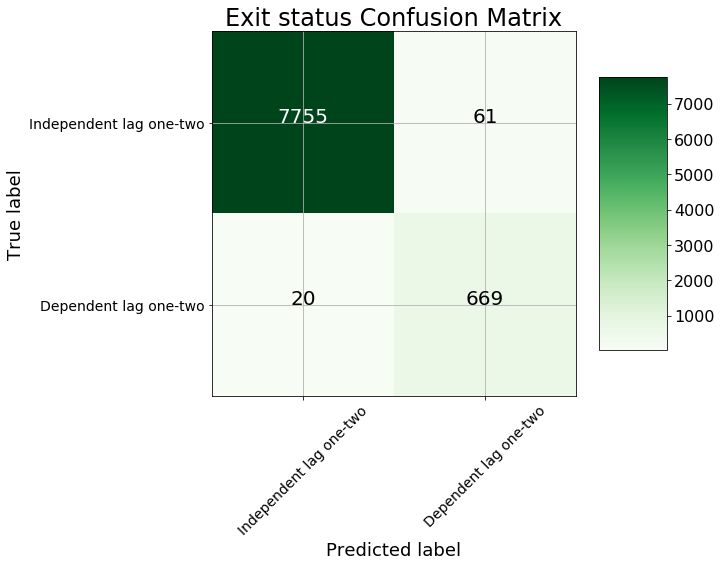

In [6]:
#EVALUATION
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

train_probs = model.predict_proba(X_train)[:,1] 
probs = model.predict_proba(X_test)[:, 1]
train_predictions = model.predict(X_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')


# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,lag="One_Two", classes = ['Independent lag one-two', 'Dependent lag one-two'],
                      title = 'Exit status Confusion Matrix')

In [7]:
## Interpreting the RF-model / variable importance with SHAP values
explainer = shap.TreeExplainer(model,data=X_train[:500],feature_perturbation='interventional')
print("finished explainer")
#shap_values = shap.TreeExplainer(model).shap_values(X_test[:1000])
#print("finished computing shap, building plot")
#shap_values = explainer.shap_values(X_test,)

finished explainer


In [8]:
shap_values = explainer.shap_values(X_test,approximate=False)

100%|===================| 17005/17010 [73:22<00:01]        

In [ ]:
from matplotlib import colors as plt_colors

shap.summary_plot(shap_values[1],X_test,max_display=5, show=False,plot_type="dot")
f=np.max(X_test["Maximum age"])
f2=np.min(X_test["Maximum age"])
print(f,f2)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(12)

ax = plt.gca()
# Plot the summary without showing it
#plt.figure()
#shap.summary_plot(shap_values[1],X_test,max_display=10, show=False,plot_type="dot")
#shap.summary_plot(shap_values_XGB_train, X_train, show=False)

# Change the colormap of the artists
my_cmap = plt.get_cmap('bwr')

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

cb = plt.colorbar(ticks=[2.774999996,30.857142857142897])
cb.set_label(label='Feature value', size='large',weight="bold",fontname="Arial",labelpad=-10)
cb.ax.set_yticklabels(["Low", "High"],weight="bold",fontname="Arial") 
#cb.ax.tick_params(labelsize='large')
#ax.set_xticklabels(rotation=180)


plt.title("Feature importance 1-2 year time-lag",fontweight="bold",fontname="Arial")
plt.xlabel("SHAP value (impact on model output)",fontweight="bold",fontname="Arial",fontsize=20)

#cbar = plt.colorbar(heatmap)
#cbar.ax.set_yticklabels(['0','1','2','>3'])
#cbar.set_label('# of contacts', rotation=270)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")
# Plot the summary without showing it
plt.figure()
#plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
plt.show()
output_dir = "/Users/markrademaker/Projects/Sea-scape-analysis/RF/"
fig.savefig(output_dir+'SHAP_Lag_one_two_RF.png', dpi = 300, bbox_inches='tight')

In [ ]:
shap.dependence_plot("Diff UQL Juv", shap_values[1], X_test,show=False,dot_size=60,alpha=0.5)#interaction_index=None

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)
ax = plt.gca()
#plt.xlim(left=0,right=1000000)
plt.xlabel("Diff UQL Juv",fontweight="bold",fontname="Arial",fontsize=20)
plt.ylabel("SHAP value",fontweight="bold",fontname="Arial",fontsize=20)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")

plt.show()



In [ ]:
inds = shap.approximate_interactions("Diff UQL Juv", shap_values[1], X_test)
# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("Diff UQL Juv", shap_values[1], X_test, interaction_index=inds[i])



In [ ]:
shap.dependence_plot("Diff LQL Juv", shap_values[1], X_test,show=False,interaction_index=None,dot_size=60,alpha=0.5)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)
ax = plt.gca()
#plt.xlim(left=0,right=1000000)
plt.xlabel("Diff UQL Juv",fontweight="bold",fontname="Arial",fontsize=20)
plt.ylabel("SHAP value",fontweight="bold",fontname="Arial",fontsize=20)

plt.xticks(fontsize=18,color='black',fontname="Arial")
plt.yticks(fontsize=18,color='black',fontname="Arial")

plt.show()




In [ ]:
inds = shap.approximate_interactions("Diff LQL Juv", shap_values[1], X_test)
# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("Diff LQL Juv", shap_values[1], X_test, interaction_index=inds[i])
